# Preparar ambiente para execução
Baixar o dataset através do repositório no GitHub

In [1]:
%%shell
rm -r -f aibox
git clone https://github.com/fabioafreitas/aibox.git

Cloning into 'aibox'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 39 (delta 5), reused 34 (delta 3), pack-reused 0
Unpacking objects: 100% (39/39), done.


### Instalar pacotes necessários

In [2]:
!pip install numpy pandas xlrd xlsxwriter matplotlib scikit-learn tensorflow keras PyWavelets scipy

     |████████████████████████████████| 143kB 45.8MB/s 


### Efetuar Imports

In [0]:
import numpy as np
import pandas as pd
import datetime as dt

from collections import OrderedDict
import xlrd
import xlsxwriter
import copy # copy.deepcopy - needed for non-shallow copy of odict object

# Visualization/plotting imports
import matplotlib as mpl
import matplotlib.pyplot as plt

# Machine learning imports
import sklearn
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
import tensorflow as tf
import keras
from keras.layers import Dense, LSTM, Input, SimpleRNN
from keras.models import Sequential, Model

import pywt # PyWavelets
from scipy import signal

from joblib import dump, load

## Resultados
falta calcular

# Dataset

In [0]:
def split_dataset_train_test(dataset, train_size, test_size):
  begin_of_split = 0
  train_list = []
  test_list = []
  while begin_of_split + train_size + test_size <= dataset.shape[0]:
    
    train = dataset[begin_of_split:begin_of_split+train_size]
    test = dataset[begin_of_split+train_size:begin_of_split+train_size+test_size]

    begin_of_split += test_size

    train_list.append(train)
    test_list.append(test)
  
  return train_list, test_list


def split_dataset_train_test_simple(dataset, train_proportion):
  train_size = int(dataset.shape[0] * train_proportion)

  data_train = dataset[:train_size]
  data_test = dataset[train_size:]

  return data_train, data_test


def split_dataset_x_y(dataset):
  x_data = dataset.drop(columns='close')
  y_data = pd.DataFrame(dataset['close'])

  return x_data, y_data


def wavelet_reconst_l2(data):
    coeffs = pywt.wavedec(data, 'haar', level=2)
    reconstructed_signal = pywt.waverec(coeffs, 'haar', mode = 'per')
    return reconstructed_signal


# https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# https://www.dataquest.io/blog/understanding-regression-error-metrics/
def mean_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean( (y_true - y_pred) / y_true) * 100



Beginning training of layer #1

Epoch 1/100
2010/2010 [==============================] - 1s 674us/step - loss: 0.0612
Epoch 2/100
2010/2010 [==============================] - 0s 92us/step - loss: 0.0391
Epoch 3/100
2010/2010 [==============================] - 0s 94us/step - loss: 0.0291
Epoch 4/100
2010/2010 [==============================] - 0s 91us/step - loss: 0.0249
Epoch 5/100
2010/2010 [==============================] - 0s 98us/step - loss: 0.0230
Epoch 6/100
2010/2010 [==============================] - 0s 98us/step - loss: 0.0220
Epoch 7/100
2010/2010 [==============================] - 0s 94us/step - loss: 0.0212
Epoch 8/100
2010/2010 [==============================] - 0s 97us/step - loss: 0.0204
Epoch 9/100
2010/2010 [==============================] - 0s 104us/step - loss: 0.0197
Epoch 10/100
2010/2010 [==============================] - 0s 103us/step - loss: 0.0189
Epoch 11/100
2010/2010 [==============================] - 0s 97us/step - loss: 0.0181
Epoch 12/100
2010/2010 [===

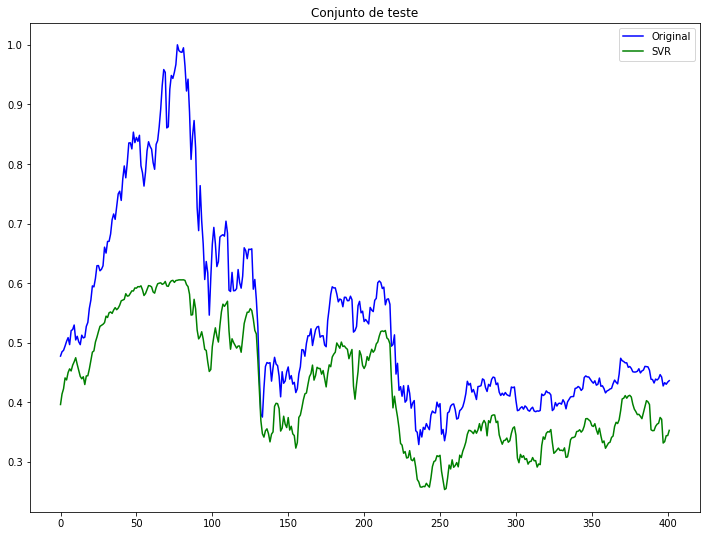

model performance:
mse: 0.017288432655046492 rmse: 0.13148548457927398 mape: 19.557864666787392 mpe: 19.557864666787392 mae: 0.10986316270123873


'\n\nEND OF MODEL EVALUATION\n\n'

In [41]:
"""

DATASET PREPARATION

"""

# Carregar de um arquivo excel e mapear cada planilha para um ordered dict
raw_xlsx_file = pd.ExcelFile("aibox/dataset/dataset.xlsx")
dict_dataframes = pd.read_excel(raw_xlsx_file,sheet_name = None)

# Criar um novo dict de dataframes para as planilhas futures
dict_dataframes_future = copy.deepcopy(dict_dataframes)
# Criar um novo dict de dataframes para as planilhas index
dict_dataframes_index =  copy.deepcopy(dict_dataframes)

# Remover planilhas index do dict com as planilhas future
del dict_dataframes_future['csi300 index data']
del dict_dataframes_future['nifty 50 index data']
del dict_dataframes_future['hangseng index data']
del dict_dataframes_future['s&p500 index data']
del dict_dataframes_future['nikkei 225 index data']
del dict_dataframes_future['djia index data']

# Remover planilhas futures do dict com as planilhas index
del dict_dataframes_index['csi300 index future data']
del dict_dataframes_index['nifty 50 index future data']
del dict_dataframes_index['hangseng index future data']
del dict_dataframes_index['s&p500 index future data']
del dict_dataframes_index['nikkei 225 index future data']
del dict_dataframes_index['djia index future data']

index_name = 'csi300 index data'
# Converter a coluna date para um objeto datetime para plot do gráfico
dict_dataframes_index[index_name]['date'] = pd.to_datetime(dict_dataframes_index[index_name]['date'].astype(str), format='%Y-%m-%d')
# Definir a coluna data como índice do dataframe
dict_dataframes_index[index_name] = dict_dataframes_index[index_name].set_index('date')

# Normalização dos dados
index_backup = dict_dataframes_index[index_name].index.copy()
columns_names = dict_dataframes_index[index_name].columns
min_max_scaler = preprocessing.MinMaxScaler()
dict_dataframes_index[index_name] = min_max_scaler.fit_transform(dict_dataframes_index[index_name])
dict_dataframes_index[index_name] = pd.DataFrame(dict_dataframes_index[index_name], columns=columns_names)
dict_dataframes_index[index_name].index = index_backup

"""

WAVELET TRANSFORMATION

"""
# Wavelet Transformation em todo a coluna de close
dict_dataframes_index[index_name]['close'] = wavelet_reconst_l2(dict_dataframes_index[index_name]['close'])
"""

END OF WAVELET TRANSFORMATION

"""
"""

AUTOENCODER

"""
dataset = dict_dataframes_index[index_name].drop(columns=['close']) # remove the output
# Parâmetros das camadas
input_dim = dataset.shape[1]
hidden_dim = 10
activation_function = 'sigmoid'
train_epochs = 100
# Modelo
stacked_autoencoder = Sequential()

# camada #1
# Entrada e Primeira camada interna
stacked_autoencoder.add( Dense(hidden_dim, activation=activation_function, input_shape=(input_dim,)) )
# Camada de saída
stacked_autoencoder.add( Dense(input_dim, activation=activation_function) )
stacked_autoencoder.compile(optimizer='adam', loss='mse')
# Treinamento
print('\nBeginning training of layer #1\n')
stacked_autoencoder.fit(dataset, dataset, epochs=train_epochs)

# Camada #2
# Remover camada de decoder do primeiro AE
stacked_autoencoder.pop()
# Bloquear atualização de pesos e bias da camada interna anterior
previous_layer = stacked_autoencoder.get_layer(index=-1)
previous_layer.trainable = False
# Adicionar nova camada interna e camada de decoder
stacked_autoencoder.add( Dense(hidden_dim, activation=activation_function) )
stacked_autoencoder.add( Dense(input_dim, activation=activation_function) )
stacked_autoencoder.compile(optimizer='adam', loss='mse')
# Treinamento
print('\nBeginning training of layer #2\n')
stacked_autoencoder.fit(dataset, dataset, epochs=train_epochs)

# Camada #3
# Remover camada de decoder do segundo AE
stacked_autoencoder.pop()
# Bloquear atualização de pesos e bias da camada interna anterior
previous_layer = stacked_autoencoder.get_layer(index=-1)
previous_layer.trainable = False
# Adicionar nova camada interna e camada de decoder
stacked_autoencoder.add( Dense(hidden_dim, activation=activation_function) )
stacked_autoencoder.add( Dense(input_dim, activation=activation_function) )
stacked_autoencoder.compile(optimizer='adam', loss='mse')
# Treinamento
print('\nBeginning training of layer #3\n')
stacked_autoencoder.fit(dataset, dataset, epochs=train_epochs)

# Camada #4
# Remover camada de decoder do terceiro AE
stacked_autoencoder.pop()
# Bloquear atualização de pesos e bias da camada interna anterior
previous_layer = stacked_autoencoder.get_layer(index=-1)
previous_layer.trainable = False
# Adicionar nova camada interna e camada de decoder
stacked_autoencoder.add( Dense(hidden_dim, activation=activation_function) )
stacked_autoencoder.add( Dense(input_dim, activation=activation_function) )
stacked_autoencoder.compile(optimizer='adam', loss='mse')
# Treinamento
print('\nBeginning training of layer #4\n')
stacked_autoencoder.fit(dataset, dataset, epochs=train_epochs)
"""

END OF AUTOENCODER MODELLING AND TRAINING

"""

# Get output from the stacked autoencoder
close_column_backup = dict_dataframes_index[index_name]['close'].copy().values
dict_dataframes_index[index_name] = dict_dataframes_index[index_name].drop(columns=['close'])
column_backup = dict_dataframes_index[index_name].columns.copy()
dict_dataframes_index[index_name] = stacked_autoencoder.predict(dict_dataframes_index[index_name])
dict_dataframes_index[index_name] = pd.DataFrame(dict_dataframes_index[index_name])
dict_dataframes_index[index_name].columns = column_backup
dict_dataframes_index[index_name]['close'] = close_column_backup


# Split treino e teste do dataset, observando a restrição de séries temporais
train_data, test_data = split_dataset_train_test_simple(dict_dataframes_index[index_name], train_proportion=0.8)

# Split entrada e saída do dataset treino
x_data_train, y_data_train = split_dataset_x_y(train_data)

x_data_train = np.reshape(x_data_train.values, (x_data_train.shape[0], x_data_train.shape[1], 1))
# y_data_train = np.reshape(y_data_train.values, (y_data_train.shape[0], y_data_train.shape[1], 1))


# Split entrada e saída do dataset teste
x_data_test, y_data_test = split_dataset_x_y(test_data)

x_data_test = np.reshape(x_data_test.values, (x_data_test.shape[0], x_data_test.shape[1], 1))
# y_data_test = np.reshape(y_data_test.values, (y_data_test.shape[0], y_data_test.shape[1], 1))


"""

SVR MODELLING AND TRAINING

"""
print('\nBeginning of SVR training:\n')
# print(x_data_train.shape)
# print(y_data_train.shape)
# print(x_data_test.shape)
# print(y_data_test.shape)

# Reshape necessario para ajustar o dado para o SVR
x_data_train = x_data_train.reshape((x_data_train.shape[0], x_data_train.shape[1]))
y_data_train = np.ravel(y_data_train) # diminuir dimensionalidade para 1d
x_data_test = x_data_test.reshape((x_data_test.shape[0], x_data_test.shape[1]))
y_data_test = np.ravel(y_data_test) # diminuir dimensionalidade para 1d

# print(40*'-')
# print(x_data_train.shape)
# print(y_data_train.shape)
# print(x_data_test.shape)
# print(y_data_test.shape)


# Criar modelo
predictor = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
# Treinamento
predictor.fit(x_data_train, y_data_train)
"""

END OF RNN MODELLING AND TRAINING

"""
"""

MODEL EVALUATION

"""
# Usar o modelo para predizer no conjunto de teste
predicted_value = predictor.predict(x_data_test)

# Fazer um plot do resultado
plt.figure(figsize=(12,9))
plt.title('Conjunto de teste')
plt.plot(y_data_test, 'blue', label='Original')
plt.plot(predicted_value, 'green', label='SVR')
plt.legend()
plt.savefig('svr_vs_original_test_set')
plt.show()

# Calcular as métricas
svr_mse = mean_squared_error(y_data_test, predicted_value)
svr_rmse = np.sqrt(svr_mse)
svr_mape = mean_absolute_percentage_error(y_data_test, predicted_value)
svr_mpe =  mean_percentage_error(y_data_test, predicted_value)
svr_mae = mean_absolute_error(y_data_test, predicted_value)

print(40*'=')
print('model performance:')
print('mse:', svr_mse, 'rmse:', svr_rmse, 'mape:', svr_mape, 'mpe:', svr_mpe, 'mae:', svr_mae)

# Salvar modelos
stacked_autoencoder.save('model_sae.h5')
dump(predictor, 'model_svr.joblib')

f = open('predicted_value.txt', 'w')
f.write(str(predicted_value))
f.close()

f = open('original_value.txt', 'w')
f.write(str(y_data_test))
f.close()

f = open('metrics_result.txt', 'w')
f.write('mse: '+str(svr_mse)+' rmse: '+str(svr_rmse)+' mape: '+str(svr_mape)+' mpe: '+str(svr_mpe)+' mae: '+str(svr_mae))
f.close()
"""

END OF MODEL EVALUATION

"""

#### Model performance

In [0]:
# Calcular as métricas
rnn_mse = mean_squared_error(y_data_test.values, predicted_value)
rnn_rmse = np.sqrt(rnn_mse)
rnn_mape = mean_absolute_percentage_error(y_data_test.values, predicted_value)
rnn_mpe =  mean_percentage_error(y_data_test.values, predicted_value)
rnn_mae = mean_absolute_error(y_data_test.values, predicted_value)

print(40*'=')
print('model performance:')
print('mse:', rnn_mse, 'rmse:', rnn_rmse, 'mape:', rnn_mape, 'mpe:', rnn_mpe, 'mae:', rnn_mae)

model performance:
mse: 0.010920443940664265 rmse: 0.10450092794164205 mape: 10.457935389870164 mpe: 10.18161019073595 mae: 0.06793110826330465


In [0]:
f = open('predicted_value.txt', 'w')
f.write(str(predicted_value))
f.close()

f = open('original_value.txt', 'w')
f.write(str(y_data_test.values))
f.close()

f = open('metrics_result.txt', 'w')
f.write('mse: '+str(rnn_mse)+' rmse: '+str(rnn_rmse)+' mape: '+str(rnn_mape)+' mpe: '+str(rnn_mpe)+' mae: '+str(rnn_mae))
f.close()

In [34]:
# Criar modelo
predictor = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
# Treinamento
predictor.fit(x_data_train, y_data_train)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

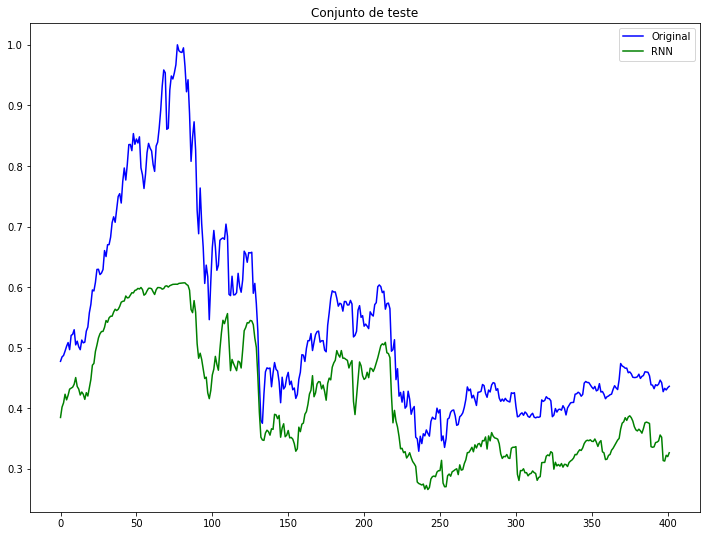

In [35]:
predicted_value = predictor.predict(x_data_test)

# Fazer um plot do resultado
plt.figure(figsize=(12,9))
plt.title('Conjunto de teste')
plt.plot(y_data_test, 'blue', label='Original')
plt.plot(predicted_value, 'green', label='RNN')
plt.legend()
plt.savefig('rnn_vs_original_test_set')
plt.show()

# Plot de todos os resultados

##### SVR

In [0]:
predicted_value_svr = '0.39623293 0.41389872 0.42265772 0.44086086 0.43751058 0.44996118 \
 0.45611227 0.45260333 0.4621843  0.46795791 0.47476811 0.46355853 \
 0.45361117 0.44347297 0.43942636 0.44280674 0.42977367 0.44422423 \
 0.44449476 0.45601387 0.46974137 0.48409145 0.48624269 0.50111226 \
 0.50936167 0.518787   0.52743043 0.52912343 0.53089486 0.53373503 \
 0.54459019 0.54231512 0.55026977 0.55157648 0.54916494 0.55484027 \
 0.55882487 0.55534649 0.55802854 0.56298985 0.5702875  0.57161465 \
 0.57274095 0.58220646 0.57815537 0.57874404 0.5829771  0.58698535 \
 0.58678844 0.59195966 0.59148075 0.59416728 0.59367702 0.59540975 \
 0.58874255 0.57922124 0.58255803 0.58898147 0.59583121 0.59531541 \
 0.59361779 0.58521229 0.58314439 0.59247407 0.59889037 0.59988476 \
 0.60056508 0.59794989 0.59919836 0.60277394 0.59517591 0.59456992 \
 0.60062434 0.60381946 0.60464596 0.60122879 0.60434831 0.60476573 \
 0.60548626 0.60537844 0.60541682 0.60552557 0.60457079 0.59748125 \
 0.59411799 0.58126495 0.54635111 0.54696545 0.57280791 0.55663032 \
 0.52151668 0.50638388 0.51022925 0.51837285 0.50615781 0.48882746 \
 0.48694227 0.46754688 0.45170063 0.45502426 0.4933897  0.51036504 \
 0.52495691 0.51106325 0.501086   0.5286212  0.55176571 0.56469608 \
 0.56100862 0.56511977 0.56959443 0.51972639 0.48906098 0.50655412 \
 0.50034234 0.4954985  0.49089695 0.4944587  0.49434749 0.48396466 \
 0.50742057 0.53218432 0.54226197 0.55117534 0.55118093 0.55717484 \
 0.55400242 0.53972645 0.52072127 0.51460444 0.47134119 0.41830976 \
 0.36880472 0.34712143 0.34151567 0.35216785 0.35542404 0.34731345 \
 0.33352793 0.34648346 0.35023387 0.39324927 0.39829757 0.39768203 \
 0.38927978 0.35166909 0.35658772 0.37661034 0.36323331 0.35753074 \
 0.37430914 0.35337327 0.35973056 0.34702614 0.3441283  0.32307078 \
 0.33231229 0.37459694 0.3785613  0.39069467 0.40436544 0.41411056 \
 0.41558987 0.42989336 0.44296205 0.44813845 0.46239799 0.4371786 \
 0.44477912 0.45871861 0.4567172  0.45671476 0.44718606 0.453259 \
 0.43907712 0.42582085 0.4479383  0.46276767 0.45972737 0.47594388 \
 0.48072545 0.48404142 0.49954944 0.4950516  0.49068353 0.50105858 \
 0.49374509 0.4944572  0.49113612 0.48887541 0.47312084 0.4815756 \
 0.48857992 0.4271764  0.40515456 0.42999041 0.45148303 0.48647267 \
 0.47913077 0.46174439 0.45674022 0.4620628  0.47662445 0.47028821 \
 0.48031837 0.48897832 0.48397774 0.48766022 0.49789818 0.50125295 \
 0.51131415 0.51883158 0.51973288 0.51870277 0.52048873 0.50798405 \
 0.50557024 0.49797385 0.43658797 0.39059026 0.41010572 0.39067483 \
 0.37554355 0.35663555 0.33092744 0.32803814 0.31449955 0.31726101 \
 0.3064675  0.30718566 0.31881078 0.30353788 0.30188977 0.30657833 \
 0.29089523 0.27040228 0.26644391 0.25790665 0.25752956 0.25885743 \
 0.25832494 0.26401196 0.26033799 0.25754429 0.27261476 0.29216617 \
 0.30053535 0.30200414 0.31033477 0.30894994 0.31102831 0.28429557 \
 0.26902013 0.25349223 0.25521828 0.27300643 0.29462624 0.28811084 \
 0.30340891 0.29088704 0.29377327 0.2988013  0.29162899 0.31122084 \
 0.30717281 0.31794512 0.32473093 0.33309504 0.34637959 0.35295563 \
 0.35241806 0.3503343  0.3473537  0.35326528 0.34809078 0.35376165 \
 0.36413323 0.35216152 0.36437806 0.3694613  0.36491268 0.34370417 \
 0.36911352 0.36569848 0.37735153 0.37875067 0.37862736 0.36589072 \
 0.36820332 0.34518892 0.33673153 0.32958898 0.33568518 0.33639749 \
 0.33992292 0.33289874 0.33553329 0.34785582 0.35649004 0.3587973 \
 0.34490144 0.30627983 0.29853394 0.31255676 0.30733206 0.31041515 \
 0.30393459 0.30544114 0.29615942 0.30046405 0.30086441 0.30719616 \
 0.30181641 0.30205723 0.29125718 0.29648525 0.29532675 0.32729954 \
 0.3418397  0.3379396  0.34789054 0.35068662 0.35002254 0.35422569 \
 0.33254048 0.31433238 0.31673226 0.32005433 0.32311031 0.31918064 \
 0.31960804 0.31844026 0.3235125  0.30751927 0.30835946 0.32118813 \
 0.33720743 0.34066972 0.34091584 0.34239519 0.35087384 0.35141669 \
 0.35389911 0.34986405 0.35296415 0.35995123 0.37231159 0.37270968 \
 0.37036729 0.36820693 0.36073527 0.35937537 0.36409935 0.35395913 \
 0.34637804 0.35648758 0.34333961 0.33228728 0.33502216 0.32280923 \
 0.32712576 0.33163269 0.3329416  0.34100729 0.34339633 0.35937457 \
 0.3663854  0.36434837 0.37066734 0.38599281 0.40566225 0.4067761 \
 0.41122925 0.40681729 0.41051882 0.41165657 0.40883269 0.39675797 \
 0.38849668 0.3843472  0.37933556 0.3797794  0.37644212 0.37250317 \
 0.38254284 0.39312389 0.40274628 0.4007106  0.39614773 0.3539219 \
 0.35229048 0.35256642 0.35953858 0.3631974  0.3648635  0.37449701 \
 0.37148558 0.33161755 0.33395834 0.34391692 0.34414027 0.35284822'

predicted_value_svr = predicted_value_svr.split()
predicted_value_svr = [float(number) for number in predicted_value_svr]
predicted_value_svr

##### LSTM

In [0]:
predicted_value_lstm = [[0.46520776],
[0.4769517 ],
[0.4828474 ],
[0.4943444 ],
[0.49196965],
[0.50108474],
[0.50346714],
[0.5025484 ],
[0.5093135 ],
[0.5125991 ],
[0.5135508 ],
[0.5045768 ],
[0.49791417],
[0.4887755 ],
[0.48959756],
[0.48929793],
[0.48117006],
[0.49227193],
[0.49203756],
[0.5041217 ],
[0.5164371 ],
[0.5337652 ],
[0.5354545 ],
[0.5473254 ],
[0.55394965],
[0.56011415],
[0.5662463 ],
[0.5674599 ],
[0.56895584],
[0.57210374],
[0.5806378 ],
[0.57904667],
[0.5856123 ],
[0.58810556],
[0.5868716 ],
[0.5913266 ],
[0.5963354 ],
[0.59380686],
[0.595279  ],
[0.59914935],
[0.6058897 ],
[0.6072665 ],
[0.60720974],
[0.6164309 ],
[0.61267245],
[0.6125702 ],
[0.6175159 ],
[0.6221021 ],
[0.6209118 ],
[0.6262908 ],
[0.62723815],
[0.6295012 ],
[0.62841016],
[0.63209224],
[0.62835306],
[0.62055093],
[0.62246156],
[0.62676233],
[0.6308648 ],
[0.6314104 ],
[0.630826  ],
[0.6259311 ],
[0.6226443 ],
[0.6280752 ],
[0.6314982 ],
[0.6311531 ],
[0.6308495 ],
[0.629035  ],
[0.63010526],
[0.63344336],
[0.6319854 ],
[0.6311014 ],
[0.6331929 ],
[0.6350847 ],
[0.63631743],
[0.6358882 ],
[0.6373313 ],
[0.6380348 ],
[0.63919175],
[0.63961494],
[0.63972884],
[0.6400826 ],
[0.6398008 ],
[0.6361129 ],
[0.6342583 ],
[0.6239253 ],
[0.59392506],
[0.5926682 ],
[0.6136868 ],
[0.59685355],
[0.56382823],
[0.5527794 ],
[0.5590326 ],
[0.5601833 ],
[0.5519808 ],
[0.5418327 ],
[0.54300344],
[0.5295274 ],
[0.52173436],
[0.530247  ],
[0.5503761 ],
[0.55595785],
[0.56475997],
[0.55561167],
[0.5496825 ],
[0.56398416],
[0.5755144 ],
[0.5845499 ],
[0.58249784],
[0.5891519 ],
[0.5934296 ],
[0.5650722 ],
[0.5406656 ],
[0.5488889 ],
[0.5444596 ],
[0.53912544],
[0.5344581 ],
[0.5404484 ],
[0.53947496],
[0.5339545 ],
[0.55099547],
[0.5733274 ],
[0.5764101 ],
[0.58109367],
[0.58167887],
[0.58459795],
[0.5832515 ],
[0.57896924],
[0.5640009 ],
[0.556035  ],
[0.53013796],
[0.4995853 ],
[0.47252628],
[0.46167853],
[0.45626342],
[0.45914927],
[0.46064353],
[0.4559631 ],
[0.44706616],
[0.45419118],
[0.45283404],
[0.46737474],
[0.46674958],
[0.46200174],
[0.4588289 ],
[0.4365548 ],
[0.43981498],
[0.45307612],
[0.44118032],
[0.43607458],
[0.4419359 ],
[0.43209174],
[0.43475363],
[0.43125185],
[0.42656863],
[0.41876796],
[0.41947502],
[0.44049066],
[0.44076568],
[0.45390865],
[0.46130514],
[0.4693102 ],
[0.47150955],
[0.48455256],
[0.49383917],
[0.49824968],
[0.50684315],
[0.4886745 ],
[0.49498123],
[0.50473917],
[0.50403565],
[0.5027189 ],
[0.49667284],
[0.5005001 ],
[0.49288702],
[0.48574895],
[0.49890238],
[0.51267827],
[0.51302516],
[0.5273292 ],
[0.532135  ],
[0.5356926 ],
[0.5450042 ],
[0.539966  ],
[0.53691244],
[0.543853  ],
[0.53587246],
[0.5365351 ],
[0.53413314],
[0.5322316 ],
[0.52555513],
[0.5294175 ],
[0.5317802 ],
[0.50487363],
[0.48614097],
[0.4965333 ],
[0.5105341 ],
[0.5311897 ],
[0.5271449 ],
[0.5152302 ],
[0.5115833 ],
[0.5137818 ],
[0.51983523],
[0.5149387 ],
[0.5222143 ],
[0.52296525],
[0.5200383 ],
[0.5245414 ],
[0.53090554],
[0.53910387],
[0.5465289 ],
[0.55183953],
[0.552809  ],
[0.5518108 ],
[0.55324584],
[0.5414076 ],
[0.5406029 ],
[0.53608125],
[0.5095302 ],
[0.47765368],
[0.48190904],
[0.48284099],
[0.469912  ],
[0.46083888],
[0.4375846 ],
[0.43866578],
[0.429791  ],
[0.42977533],
[0.421359  ],
[0.4173865 ],
[0.418895  ],
[0.41423523],
[0.40968704],
[0.4044103 ],
[0.4091406 ],
[0.3895619 ],
[0.3866963 ],
[0.3728813 ],
[0.37508866],
[0.36986428],
[0.36616695],
[0.36941504],
[0.36532506],
[0.36013827],
[0.3636796 ],
[0.37102827],
[0.3732854 ],
[0.3730676 ],
[0.37864286],
[0.3802247 ],
[0.3815153 ],
[0.38001278],
[0.36384597],
[0.35973638],
[0.35689753],
[0.36127207],
[0.37398213],
[0.36863282],
[0.3785131 ],
[0.37260485],
[0.37533006],
[0.3802035 ],
[0.3745048 ],
[0.3839194 ],
[0.38122135],
[0.38651028],
[0.39169863],
[0.39781818],
[0.41131574],
[0.41540357],
[0.4178637 ],
[0.41754946],
[0.41521484],
[0.4199715 ],
[0.41601807],
[0.41961372],
[0.4265103 ],
[0.42004114],
[0.4279468 ],
[0.4316108 ],
[0.43177447],
[0.42202857],
[0.43317395],
[0.43177974],
[0.43669894],
[0.43791947],
[0.43855396],
[0.4336445 ],
[0.43559355],
[0.42630303],
[0.4203893 ],
[0.41492414],
[0.4169447 ],
[0.41568127],
[0.41813615],
[0.41465488],
[0.41622415],
[0.42098317],
[0.42572102],
[0.42553374],
[0.42237988],
[0.4022663 ],
[0.39574578],
[0.40156725],
[0.39629632],
[0.39785844],
[0.3922894 ],
[0.39288574],
[0.387874  ],
[0.39010957],
[0.38863787],
[0.391239  ],
[0.388665  ],
[0.38781384],
[0.38330466],
[0.38422436],
[0.3835863 ],
[0.39079636],
[0.39945862],
[0.40047622],
[0.4092881 ],
[0.4125741 ],
[0.41284382],
[0.4162509 ],
[0.40629163],
[0.39472753],
[0.39433494],
[0.39763317],
[0.39851227],
[0.39899716],
[0.39859632],
[0.39713013],
[0.40189952],
[0.39390844],
[0.3911432 ],
[0.39637566],
[0.40174007],
[0.40354466],
[0.40529388],
[0.4068287 ],
[0.412599  ],
[0.4149895 ],
[0.41826186],
[0.41672733],
[0.41842422],
[0.42430606],
[0.43263978],
[0.43386966],
[0.43298534],
[0.43274328],
[0.42893723],
[0.42912945],
[0.43140453],
[0.42720118],
[0.42306164],
[0.42670223],
[0.42436185],
[0.41827184],
[0.42139167],
[0.4144269 ],
[0.41557127],
[0.41688722],
[0.41616437],
[0.41868305],
[0.41863093],
[0.42500436],
[0.42954776],
[0.42956546],
[0.4327297 ],
[0.44786355],
[0.45962706],
[0.46122274],
[0.46551192],
[0.46309602],
[0.46512422],
[0.46582416],
[0.46378016],
[0.4573587 ],
[0.45171827],
[0.44929534],
[0.4467563 ],
[0.44757864],
[0.44738778],
[0.4446027 ],
[0.449135  ],
[0.45512596],
[0.45842478],
[0.45790645],
[0.45563972],
[0.4369447 ],
[0.43508285],
[0.43450865],
[0.4351683 ],
[0.43583405],
[0.43662128],
[0.44070044],
[0.4395652 ],
[0.4140494 ],
[0.41346964],
[0.42207602],
[0.41875026],
[0.42387748]]

predicted_value_lstm = np.ravel(predicted_value_lstm)
predicted_value_lstm

##### RNN

In [0]:
predicted_value_rnn = [[0.44818503],
[0.45967653],
[0.4679232 ],
[0.47968295],
[0.48231375],
[0.49210897],
[0.49678525],
[0.486415  ],
[0.49783823],
[0.50488484],
[0.5104465 ],
[0.49836937],
[0.4875242 ],
[0.47340986],
[0.47319046],
[0.46928024],
[0.45979545],
[0.47110942],
[0.4726881 ],
[0.4792826 ],
[0.49319836],
[0.51330423],
[0.51648104],
[0.53620034],
[0.5502911 ],
[0.56116414],
[0.56792516],
[0.5706451 ],
[0.57395107],
[0.5783283 ],
[0.5894075 ],
[0.5852872 ],
[0.59583026],
[0.5996517 ],
[0.5962715 ],
[0.6018359 ],
[0.605852  ],
[0.60264045],
[0.6070579 ],
[0.6135783 ],
[0.62351805],
[0.6261329 ],
[0.6262447 ],
[0.63705444],
[0.63329023],
[0.63273305],
[0.6374259 ],
[0.6428567 ],
[0.642109  ],
[0.64667004],
[0.6476768 ],
[0.6498756 ],
[0.64904934],
[0.6478277 ],
[0.63876617],
[0.6226406 ],
[0.6274316 ],
[0.63551134],
[0.6442846 ],
[0.64273214],
[0.63928986],
[0.62600195],
[0.6204148 ],
[0.6384418 ],
[0.64712167],
[0.65018135],
[0.6516464 ],
[0.65068346],
[0.6508279 ],
[0.6530918 ],
[0.64892066],
[0.64433706],
[0.65114295],
[0.65430045],
[0.65481246],
[0.65363306],
[0.6542989 ],
[0.65553755],
[0.65530413],
[0.6553172 ],
[0.6546897 ],
[0.6540611 ],
[0.6527975 ],
[0.644154  ],
[0.63944656],
[0.62061197],
[0.57563615],
[0.5722759 ],
[0.598059  ],
[0.57201463],
[0.51723593],
[0.49516985],
[0.49592528],
[0.50178576],
[0.49182323],
[0.4746205 ],
[0.47047433],
[0.46277437],
[0.4565107 ],
[0.45345262],
[0.47220486],
[0.48351607],
[0.5033321 ],
[0.4911258 ],
[0.47593257],
[0.5092473 ],
[0.5457863 ],
[0.58576053],
[0.5724271 ],
[0.5963345 ],
[0.61308634],
[0.5289458 ],
[0.49281946],
[0.5066371 ],
[0.5028222 ],
[0.5051838 ],
[0.49797872],
[0.50289375],
[0.5023072 ],
[0.49650803],
[0.52081716],
[0.5550406 ],
[0.5679755 ],
[0.58875567],
[0.5919992 ],
[0.59115595],
[0.5951967 ],
[0.57544124],
[0.5536469 ],
[0.53282607],
[0.4999216 ],
[0.45894638],
[0.43269756],
[0.41808358],
[0.41506192],
[0.41934717],
[0.41532263],
[0.40904772],
[0.40239945],
[0.41027513],
[0.40652406],
[0.428338  ],
[0.43620938],
[0.44926485],
[0.45396915],
[0.42520523],
[0.4268863 ],
[0.43235338],
[0.41959688],
[0.41900724],
[0.4291803 ],
[0.4199632 ],
[0.42016178],
[0.41159284],
[0.4077558 ],
[0.40427324],
[0.40472338],
[0.4338561 ],
[0.43463215],
[0.4472178 ],
[0.45766637],
[0.4643439 ],
[0.46212515],
[0.4784731 ],
[0.48474142],
[0.49336794],
[0.503248  ],
[0.48195556],
[0.4880508 ],
[0.4964473 ],
[0.49209931],
[0.48377833],
[0.48115566],
[0.48806366],
[0.47678822],
[0.46503162],
[0.47548068],
[0.4894402 ],
[0.49505338],
[0.5101192 ],
[0.5116512 ],
[0.51624846],
[0.52985877],
[0.5214179 ],
[0.51495737],
[0.5280704 ],
[0.5233326 ],
[0.5301605 ],
[0.52060795],
[0.5152412 ],
[0.50468117],
[0.5061979 ],
[0.50877535],
[0.47969803],
[0.46322098],
[0.46931428],
[0.48035982],
[0.51437634],
[0.507526  ],
[0.49185017],
[0.48732936],
[0.49210253],
[0.49315283],
[0.48680776],
[0.49825147],
[0.5120304 ],
[0.5081276 ],
[0.5096812 ],
[0.5144724 ],
[0.5211697 ],
[0.5363018 ],
[0.5424249 ],
[0.5483518 ],
[0.54905057],
[0.54909354],
[0.5329963 ],
[0.5295653 ],
[0.52236766],
[0.48304817],
[0.45477808],
[0.4566507 ],
[0.44315988],
[0.43505755],
[0.42389932],
[0.4093324 ],
[0.40826842],
[0.40273577],
[0.3979656 ],
[0.3919    ],
[0.3904734 ],
[0.39455292],
[0.38981217],
[0.38354382],
[0.38438198],
[0.38288093],
[0.37218812],
[0.36716467],
[0.358611  ],
[0.3605082 ],
[0.35821113],
[0.35198662],
[0.35440806],
[0.35181782],
[0.3475486 ],
[0.35544005],
[0.3672223 ],
[0.37582114],
[0.375478  ],
[0.38171983],
[0.37765604],
[0.3797058 ],
[0.36614996],
[0.35075495],
[0.3464354 ],
[0.3452009 ],
[0.35320675],
[0.36629352],
[0.3611086 ],
[0.37114632],
[0.3625101 ],
[0.35957864],
[0.36687654],
[0.35965717],
[0.37547448],
[0.37476596],
[0.38533077],
[0.39082432],
[0.39269024],
[0.40291762],
[0.40723702],
[0.404455  ],
[0.40153667],
[0.4018336 ],
[0.40795302],
[0.40728006],
[0.41065383],
[0.4208338 ],
[0.41561422],
[0.4205933 ],
[0.42506966],
[0.41877416],
[0.41237894],
[0.42221057],
[0.42272815],
[0.42645052],
[0.4302131 ],
[0.43333337],
[0.42552355],
[0.42887256],
[0.41775745],
[0.40794393],
[0.40275788],
[0.40661705],
[0.4084315 ],
[0.40949252],
[0.40790665],
[0.4079859 ],
[0.4141356 ],
[0.41858253],
[0.41899976],
[0.41136643],
[0.39502805],
[0.38662258],
[0.39158264],
[0.38713443],
[0.38693655],
[0.3834003 ],
[0.38409716],
[0.37698695],
[0.3759914 ],
[0.37418976],
[0.37838146],
[0.37650332],
[0.37843755],
[0.3728648 ],
[0.37339774],
[0.3722582 ],
[0.38733453],
[0.40114596],
[0.39897007],
[0.40867308],
[0.41101065],
[0.41088504],
[0.4137806 ],
[0.39845532],
[0.38626298],
[0.3899314 ],
[0.39315292],
[0.3958336 ],
[0.39399087],
[0.39195094],
[0.39234573],
[0.3968064 ],
[0.37937957],
[0.37611598],
[0.385564  ],
[0.39842042],
[0.4005278 ],
[0.40004686],
[0.39998716],
[0.4070581 ],
[0.40674192],
[0.40755633],
[0.40485775],
[0.40666595],
[0.4134837 ],
[0.42279804],
[0.42284936],
[0.42042014],
[0.4191245 ],
[0.41311023],
[0.4109292 ],
[0.41349503],
[0.40736866],
[0.4055956 ],
[0.41114643],
[0.40902194],
[0.40164465],
[0.40818432],
[0.40166113],
[0.40336654],
[0.40368974],
[0.40200844],
[0.40382835],
[0.4046722 ],
[0.41443133],
[0.42063093],
[0.41628125],
[0.42141947],
[0.4332526 ],
[0.4523488 ],
[0.4550483 ],
[0.45975313],
[0.45694774],
[0.45888007],
[0.45865956],
[0.45461085],
[0.4482895 ],
[0.44341028],
[0.4405294 ],
[0.4340334 ],
[0.4316601 ],
[0.43293726],
[0.42877254],
[0.43432373],
[0.4431721 ],
[0.44879583],
[0.44748828],
[0.443445  ],
[0.42912397],
[0.42325982],
[0.4220462 ],
[0.42049327],
[0.42017838],
[0.42420015],
[0.42939234],
[0.42738894],
[0.41784683],
[0.4149887 ],
[0.41798726],
[0.4190298 ],
[0.42419106]]

predicted_value_rnn = np.ravel(predicted_value_rnn)
predicted_value_rnn

##### Plot

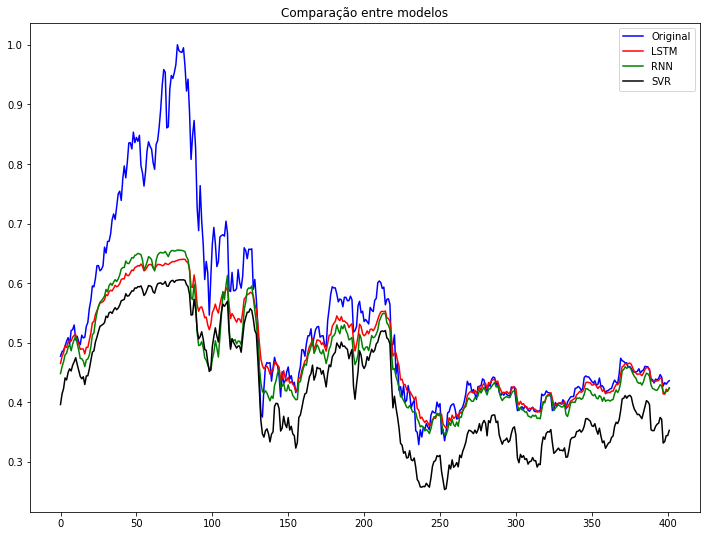

In [65]:
plt.figure(figsize=(12,9))
plt.title('Comparação entre modelos')
plt.plot(y_data_test, 'blue', label='Original')
plt.plot(predicted_value_lstm, 'red', label='LSTM')
plt.plot(predicted_value_rnn, 'green', label='RNN')
plt.plot(predicted_value_svr, 'black', label='SVR')
plt.legend()
plt.savefig('comparation_of_models')
plt.show()